In [1]:
# LDA2 and LDA3

import torch
import numpy as np
import torch.nn as nn
from pathlib import Path
import matplotlib.pyplot as plt
import os
import math
import csv 
import re # for reading data from txt files

from distmesh import *
from FEM_TPT import *

Natoms = 8
dim = 3
Nmin = 8
beta = 10

In [2]:
def read_FEdata_files(beta):
    fname = "Data/LJ"+str(Natoms) + "free_energy_beta"+str(beta)+".txt"

    # read free energy
    FE = []
    with open(fname, "r") as f:
        for line in f:
            # cleaning the bad chars in line
            line = line.strip()
            line = line.strip(" \\n")
            line = re.sub(r"(-[0-9]+\.)", r" \1", line)
            values = [float(value) for value in line.split()]
            FE.append(values)
        print(np.shape(FE))
        FE = np.array(FE)
        print(np.shape(FE))

    # read the bicubic matrix file
    fname = "Data/LJ"+str(Natoms) + "free_energy_bicubic_matrix_beta"+str(beta)+".txt"

    bicubic_matrix = [] 
    with open(fname, "r") as f:
        for line in f:
            # cleaning the bad chars in line
            line = line.strip()
            line = line.strip(" \\n")
            line = re.sub(r"(-[0-9]+\.)", r" \1", line)
            values = [float(value) for value in line.split()]
            bicubic_matrix.append(values)
    print(np.shape(bicubic_matrix))
    bicubic_matrix = np.array(bicubic_matrix)
    print(np.shape(bicubic_matrix))
    return FE,bicubic_matrix

def read_Mdata_files(entry,beta):
    fname = "Data/LJ"+str(Natoms) + "_M" + str(entry) + "_beta" + str(beta) + ".txt"

    # read free energy
    M = []
    with open(fname, "r") as f:
        for line in f:
            # cleaning the bad chars in line
            line = line.strip()
            line = line.strip(" \\n")
            line = re.sub(r"(-[0-9]+\.)", r" \1", line)
            values = [float(value) for value in line.split()]
            M.append(values)
        print(np.shape(M))
        M = np.array(M)
        print(np.shape(M))

    # read the bicubic matrix file
    fname = "Data/LJ"+str(Natoms) + "_M" + str(entry) + "_bicubic_matrix_beta" + str(beta) + ".txt"

    bicubic_matrix = [] 
    with open(fname, "r") as f:
        for line in f:
            # cleaning the bad chars in line
            line = line.strip()
            line = line.strip(" \\n")
            line = re.sub(r"(-[0-9]+\.)", r" \1", line)
            values = [float(value) for value in line.split()]
            bicubic_matrix.append(values)
    print(np.shape(bicubic_matrix))
    bicubic_matrix = np.array(bicubic_matrix)
    print(np.shape(bicubic_matrix))
    return M,bicubic_matrix

def bicubic_interpolation(bicubic_matrix,xgrid,ygrid,dx,dy,x,y):
    # FEval(x,y) = \sum_{i,j=0}^3 a(i,j)x^i y^j
    # FEder1(x,y) = \sum_{i=1}^3\sum{j=0}^3 a(i,j)ix^{i-1} y^j
    # FEder2(x,y) = \sum_{i=0}^3\sum{j=1}^3 a(i,j)jx^i y^{j-1}
    N1 = np.size(xgrid)
    N2 = np.size(ygrid)
   
    # find the cell
    i = min(max(0,int(np.floor((x - xgrid[0])/dx))),N1-2)
    j = min(max(0,int(np.floor((y - ygrid[0])/dy))),N2-2)
    x = (x - xgrid[0] - dx*i)/dx # x in cell rescaled to [0,1]
    y = (y - ygrid[0] - dy*j)/dy # y in cell rescaled to [0,1]
    
    ind = i + N1*j
    ishift = ind
    val = 0.0
    grad_x = 0.0
    grad_y = 0.0
    for i in range(4):
        for j in range(4):
            val = val + bicubic_matrix[ishift,i*4 + j]*(x**i)*(y**j)

#     for i in range(1,4):
#         for j in range(4):
#             grad_x = grad_x + bicubic_matrix[ishift,i*4 + j]*i*(x**(i-1))*(y**j)

#     for i in range(4):
#         for j in range(1,4):
#             grad_y = grad_y + bicubic_matrix[ishift,i*4 + j]*(x**i)*j*(y**(j-1))
    
#     grad_x = grad_x/dx
#     grad_y = grad_y/dy
    
    return val #,grad_x,grad_y


In [3]:
# draw ellipse
def compute_ellipse_data(x0,y0,M,scale):
    evals,evecs = np.linalg.eig(M)
    t = np.linspace(0,2*np.pi,50)
    x = x0 + scale*(evecs[0,0]*evals[0]*np.cos(t) + evecs[0,1]*evals[1]*np.sin(t))
    y = y0 + scale*(evecs[1,0]*evals[0]*np.cos(t) + evecs[1,1]*evals[1]*np.sin(t))
    return x,y


In [4]:
# read the parameter file
fname = "Data/bicubic_params.txt"
line_count = 0
with open(fname, "r") as f:
    for line in f:
        line = line.strip()
        line = line.strip(" \\n")
        line = re.sub(r"(-[0-9]+\.)", r" \1", line)
        print(line)
        line_count = line_count + 1
        if line_count == 1:
            N1 = int(line)
        elif line_count == 2:
            N2 = int(line)
        elif line_count == 3:
            h1 = float(line)
        elif line_count == 4:
            h2 = float(line)
        elif line_count == 5:    
            val1_min = float(line)
        elif line_count == 6: 
            val1_max = float(line)
        elif line_count == 7:
            val2_min = float(line)
        elif line_count == 8: 
            val2_max = float(line)
print(N1)
print(N2)
print(h1)
print(h2)
print(val1_min)
print(val1_max)
print(val2_min)
print(val2_max)


129
129
2.1429852405e-02
1.6717075150e-02
 -3.6626064036e+00
 -9.1958529575e-01
1.2550241383e-02
2.1523358606e+00
129
129
0.021429852405
0.01671707515
-3.6626064036
-0.91958529575
0.012550241383
2.1523358606


In [5]:
# read data files
FE, bicubic_matrix = read_FEdata_files(beta)
M11, M11_bicubic_matrix = read_Mdata_files(11,beta)
M12, M12_bicubic_matrix = read_Mdata_files(12,beta)
M22, M22_bicubic_matrix = read_Mdata_files(22,beta)


(129, 129)
(129, 129)
(16641, 16)
(16641, 16)
(129, 129)
(129, 129)
(16641, 16)
(16641, 16)
(129, 129)
(129, 129)
(16641, 16)
(16641, 16)
(129, 129)
(129, 129)
(16641, 16)
(16641, 16)


In [6]:
# visualize the free energy
CV1grid = np.linspace(val1_min,val1_max,N1)
CV2grid = np.linspace(val2_min,val2_max,N1)

def contourf_func(func,beta,x,y,str_func,fig_name):
    plt.rcParams.update({'font.size': 20})
    plt.figure(figsize=(8,8))
    plt.contourf(x,y,func, levels=60, cmap='turbo')
    cbar = plt.colorbar()
    cbar.set_label(str_func, size=20)
    plt.xlabel("CV1")
    plt.ylabel("CV2")
    plt.title(r'$\beta$' + ' = ' + str(beta))
    axes=plt.gca()
    #axes.set_aspect(1)
    plt.savefig(fig_name)

In [7]:
dir = "Data/"
LDAmatrix = np.loadtxt(dir+"LDAbasis.csv", delimiter=',', dtype=float)

def Dist_Sq_Matrix(x): # matrix of distances squared
    Na = np.size(x,axis = 1)
    D2 = np.zeros((Na,Na))
    for j in range(Na):
        D2[j,:] = (x[0,:]-x[0,j])**2 + (x[1,:]-x[1,j])**2 + (x[2,:]-x[2,j])**2
    return D2

def sort_coord_num(x):
    Na = np.size(x,axis = 1)
    D2 = Dist_Sq_Matrix(x)
    coord_num = np.zeros((Na,))
    for j in range(Na):
        ind = np.setdiff1d(range(Na),np.array([j]))
        aux = (D2[j,ind]/2.25)**4
        coord_num[j] = np.sum((np.ones((1,Na-1))-aux)/(np.ones((1,Na-1))-aux**2))
    return np.sort(coord_num) 

# def sortdist2(xyz):
#     d2 = np.zeros(int((Natoms*(Natoms-1)/2),))
#     count = 0
#     for j in range(1,Natoms):
#         for k in range(j):
#             d2[count] = np.sum((xyz[:,j]-xyz[:,k])**2)
#             count = count + 1
#     return np.sort(d2)        
            
def CV(xyz):
    sort_cnum = sort_coord_num(xyz)
    LDAcv = np.matmul(sort_cnum,LDAmatrix)
    return LDAcv


In [8]:
# load the list of minima and saddles of LJ7 in 2D
XYZlist = np.loadtxt("LJ8data/min_xyz.csv", delimiter=',', dtype=float)
# format: each row x0,x1,...,x7,y0,y1,...,y7,z0,z1,...,z7
CVlist = np.zeros((Nmin,2))
for j in range(Nmin):
    CVlist[j,0],CVlist[j,1] = CV(np.reshape(XYZlist[3*j:3*(j+1),:],(dim,Natoms)))


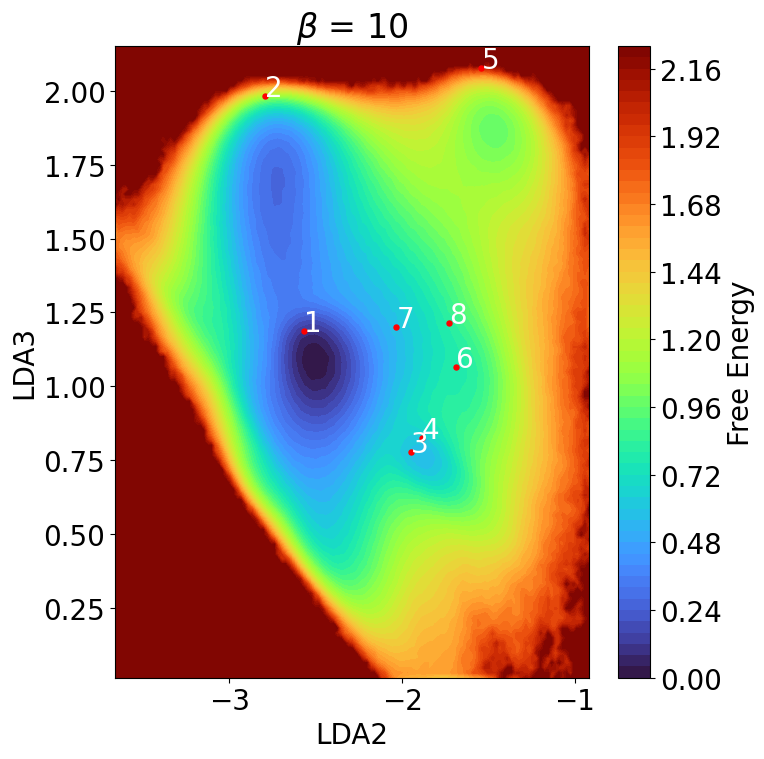

In [9]:
fig_name = "Figures/FE_LJ"+str(Natoms)+"in"+str(dim)+"Dbeta" + str(beta) + "_LDA23.pdf"
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(8,8))
# ax = fig.add_subplot(111)
plt.contourf(CV1grid,CV2grid,FE, levels=60, cmap='turbo')
cbar = plt.colorbar()
cbar.set_label("Free Energy", size=20)
plt.xlabel("LDA2")
plt.ylabel("LDA3")
plt.title(r'$\beta$' + ' = ' + str(beta))
plt.scatter(CVlist[:,0],CVlist[:,1],s = 13, c = 'red')
# plt.contour(CV1grid,CV2grid,FE, levels=[0.5])

# plt.plot(CVmep[:,0],CVmep[:,1],color = "white")
# print(CVlist)
for j in range(Nmin):
    plt.text(CVlist[j,0],CVlist[j,1],str(j+1),color = 'white')
plt.tight_layout()
plt.savefig(fig_name)

In [10]:
def visualize_diffusion_matrix(func,M11,M12,M22,beta,step,x,y,str_func,fig_name):
    plt.rcParams.update({'font.size': 20})
    plt.figure(figsize=(8,8))
    plt.contour(x,y,func, levels=60, cmap='turbo')
    cbar = plt.colorbar()
    cbar.set_label(str_func, size=20)
    plt.xlabel("CV1")
    plt.ylabel("CV2")
    plt.title(r'$\beta$' + ' = ' + str(beta))
    axes=plt.gca()
    N2,N1 = np.shape(func)
    scale = 2e-3
    for i in range(0,N1,step):
        for j in range(0,N2,step):
            M = np.array([[M11[j,i],M12[j,i]],[M12[j,i],M22[j,i]]]);
            edata0,edata1 = compute_ellipse_data(x[i],y[j],M,scale)
            plt.plot(edata0,edata1,color = "black",linewidth = 0.5)
    plt.savefig(fig_name)

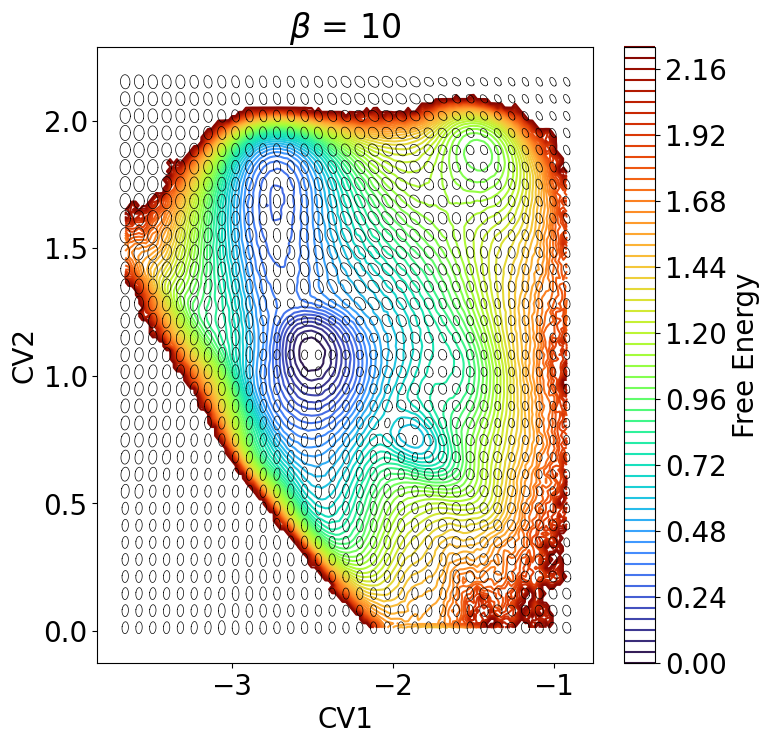

In [11]:
step = 4
fname = "Figures/LJ"+str(Natoms)+"_FE_DiffMatr_beta"+str(beta)+".pdf"
visualize_diffusion_matrix(FE,M11,M12,M22,beta,step,CV1grid,CV2grid,"Free Energy",fname)

0.0003216324973546214
region A:  -2.7647490598531927 1.7644522510665728


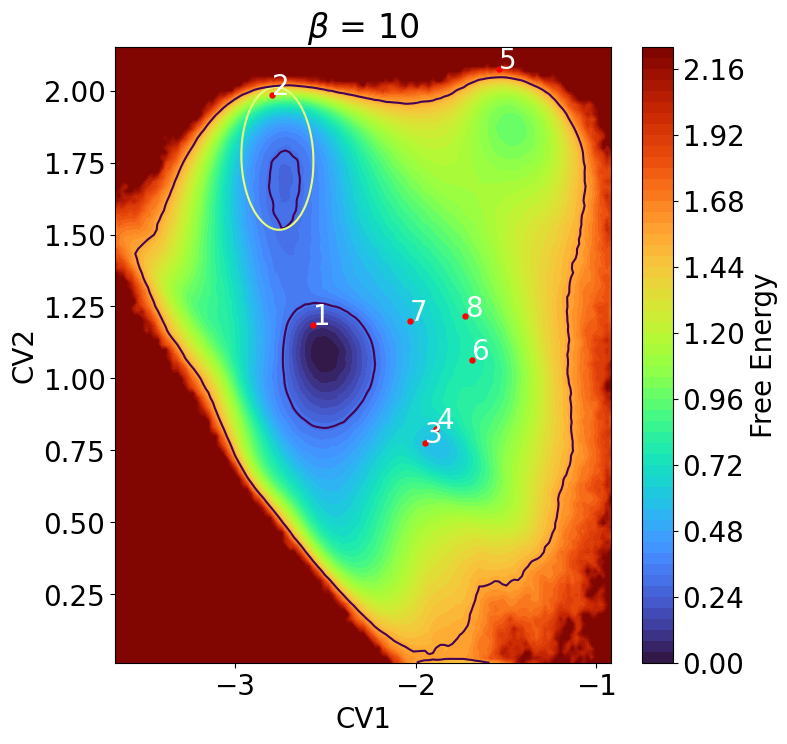

In [12]:
# === Set region parameters by beta ===

feB = 0.3
x0 = CVlist[1,0]+0.03
y0 = CVlist[1,1]-0.22
vx = -0.1
vy = 1.0
r0 = 0.25
r1 = 0.2
if beta == 10:
    fe_outer = 1.55
elif beta == 15:
    feB = 0.3
elif beta == 20:
    fe_outer = 1.32
else:
    raise ValueError(f"Beta value {beta} is not yet configured.")

# === Plot Free Energy landscape ===
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(8,8))
plt.contourf(CV1grid, CV2grid, FE, levels=60, cmap='turbo')
cbar = plt.colorbar()
cbar.set_label("Free Energy", size=20)
plt.xlabel("CV1")
plt.ylabel("CV2")
plt.title(r'$\beta$ = ' + str(beta))
plt.scatter(CVlist[:,0], CVlist[:,1], s=13, c='red')

# Plot B region (contour at feB)
plt.contour(CV1grid, CV2grid, FE, levels=[feB])

# Label minima
for j in range(Nmin):
    plt.text(CVlist[j,0], CVlist[j,1], str(j+1), color='white')

# === Compute and plot region B boundary ===
cB = plt.contour(CV1grid, CV2grid, FE, [feB])
level_set_B = cB.allsegs[0]
Bbdry = reparametrization(level_set_B[:85], 0.02)
plt.scatter(Bbdry[:,0], Bbdry[:,1], s=10, c='blue')

# === Compute and plot region O boundary ===
outer_bdry = plt.contour(CV1grid, CV2grid, FE, [fe_outer])
level_set_O = outer_bdry.allsegs[0]
Obdry = level_set_O  # optionally: reparametrize
plt.scatter(Obdry[:,0], Obdry[:,1], s=10, c='red')

# === Define region A (ellipse) ===
Nt = 50
t = np.linspace(0, 2*np.pi, Nt)
vec0 = np.array([vx, vy])
vec1 = np.array([-vec0[1], vec0[0]])
x = x0 + (r0*vec0[0]*np.cos(t) + r1*vec1[0]*np.sin(t))
y = y0 + (r0*vec0[1]*np.cos(t) + r1*vec1[1]*np.sin(t))
plt.plot(x, y, color="black", linewidth=2)

bb = np.stack((x, y), axis=1)
Abdry = reparametrization(bb, 0.02)
plt.scatter(Abdry[:,0], Abdry[:,1], s=10, c='green')

# === Print sizes for verification ===
print("Region A size:", np.size(Abdry))
print("Region B size:", np.size(Bbdry))
print("Region O size:", np.size(Obdry))

# === Optionally save boundaries ===
# dirname = f"FEMdataBETA{beta}/"
# np.savetxt(dirname + "A_bdry.csv", Abdry, delimiter=",")
# np.savetxt(dirname + "B_bdry.csv", Bbdry, delimiter=",")
# np.savetxt(dirname + "O_bdry.csv", Obdry, delimiter=",")


tri shape:  FEMdataBETA10/ (33432, 3)
OmegaAB: Npts =  18485  Ntri =  33432
A: NptsA =  631  NtriA =  1120
B: NptsB =  593  NtriB =  1036


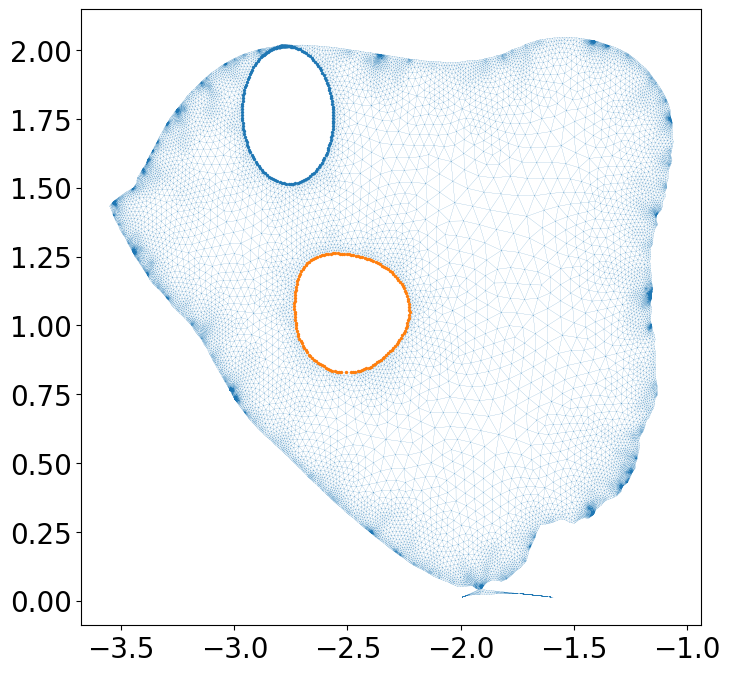

In [14]:
# The triangulation is done using Darren Engwirda's triangulation package mesh2D
# https://github.com/dengwirda/mesh2d?tab=readme-ov-file

# Read the triangulation files
Aind = np.loadtxt(dirname +"Abdry.csv", delimiter=',', dtype=int)
Bind = np.loadtxt(dirname +"Bbdry.csv", delimiter=',', dtype=int)
pts = np.loadtxt(dirname +"pts.csv", delimiter=',', dtype=float)
ptsA = np.loadtxt(dirname +"ptsA.csv", delimiter=',', dtype=float)
ptsB = np.loadtxt(dirname +"ptsB.csv", delimiter=',', dtype=float)
tri = np.loadtxt(dirname +"tri.csv", delimiter=',', dtype=int)

print('tri shape: ', dirname, tri.shape)
triA = np.loadtxt(dirname +"triA.csv", delimiter=',', dtype=int)
triB = np.loadtxt(dirname +"triB.csv", delimiter=',', dtype=int)

Npts = np.size(pts,axis = 0)
Ntri = np.size(tri,axis = 0)
NptsA = np.size(ptsA,axis = 0)
NtriA = np.size(triA,axis = 0)
NptsB = np.size(ptsB,axis = 0)
NtriB = np.size(triB,axis = 0)

print("OmegaAB: Npts = ",Npts," Ntri = ",Ntri)
print("A: NptsA = ",NptsA," NtriA = ",NtriA)
print("B: NptsB = ",NptsB," NtriB = ",NtriB)

plt.figure(figsize=(8,8))
plt.triplot(pts[:,0],pts[:,1],tri,linewidth=0.1)
plt.scatter(pts[Aind,0],pts[Aind,1],s = 2)
plt.scatter(pts[Bind,0],pts[Bind,1],s = 2)
# plt.savefig('LJ72D_trimesh_ABellipses.pdf')


In [15]:
# ise the bicubic interpolation to interpolate the free energy and the diffusion matrix 
# to the nodes of the triangulated mesh

# FE7, bicubic_matrix7 = read_FEdata_files(beta)
# M11_7, M11_bicubic_matrix7 = read_Mdata_files(11,beta)
# M12_7, M12_bicubic_matrix7 = read_Mdata_files(12,beta)
# M22_7, M22_bicubic_matrix7 = read_Mdata_files(22,beta)

Fpts = np.zeros((Npts,))
M11pts = np.zeros((Npts,))
M12pts = np.zeros((Npts,))
M22pts = np.zeros((Npts,))
FptsA = np.zeros((NptsA,))
FptsB = np.zeros((NptsB,))

for j in range(Npts):
    Fpts[j] = bicubic_interpolation(bicubic_matrix,CV1grid,CV2grid,h1,h2,pts[j,0],pts[j,1])
    M11pts[j] = bicubic_interpolation(M11_bicubic_matrix,CV1grid,CV2grid,h1,h2,pts[j,0],pts[j,1])
    M12pts[j] = bicubic_interpolation(M12_bicubic_matrix,CV1grid,CV2grid,h1,h2,pts[j,0],pts[j,1])
    M22pts[j] = bicubic_interpolation(M22_bicubic_matrix,CV1grid,CV2grid,h1,h2,pts[j,0],pts[j,1])
    
for j in range(NptsA):
    FptsA[j] = bicubic_interpolation(bicubic_matrix,CV1grid,CV2grid,h1,h2,ptsA[j,0],ptsA[j,1])

for j in range(NptsB):
    FptsB[j] = bicubic_interpolation(bicubic_matrix,CV1grid,CV2grid,h1,h2,ptsB[j,0],ptsB[j,1])

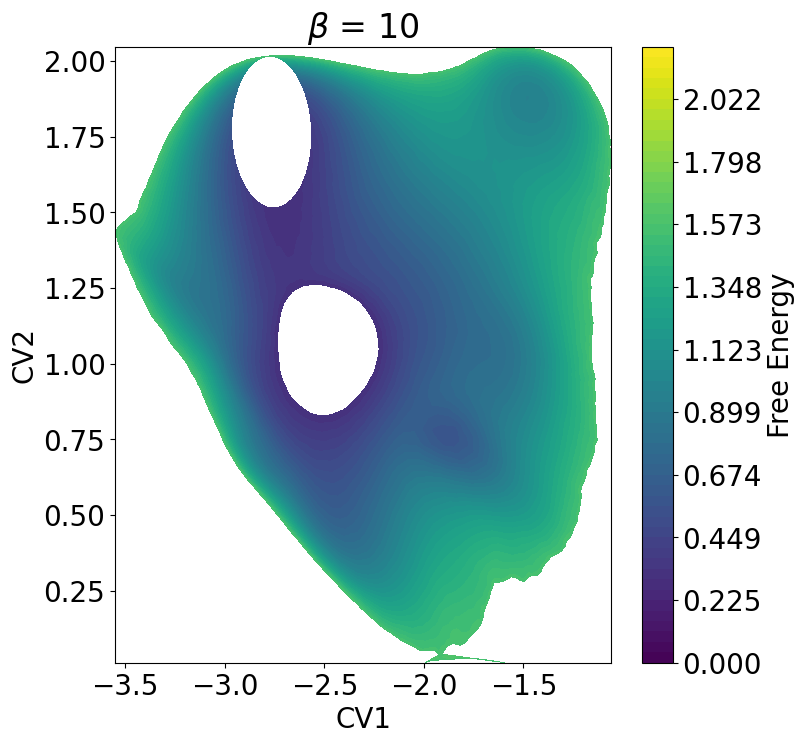

In [16]:
plt.figure(figsize=(8,8))    
plt.tricontourf(pts[:,0], pts[:,1],tri,Fpts,np.linspace(np.min(FE),np.max(FE),60) )
cbar = plt.colorbar()
cbar.set_label("Free Energy", size=20)
plt.xlabel("CV1")
plt.ylabel("CV2")
plt.title(r'$\beta$' + ' = ' + str(beta))
axes=plt.gca()


In [17]:
# find the committor
q = FEM_committor_solver_var_diffusion_matrix(pts,tri,Aind,Bind,Fpts,M11pts,M12pts,M22pts,beta)


In [18]:
print(np.min(q))
print(np.max(q))

0.0
1.0


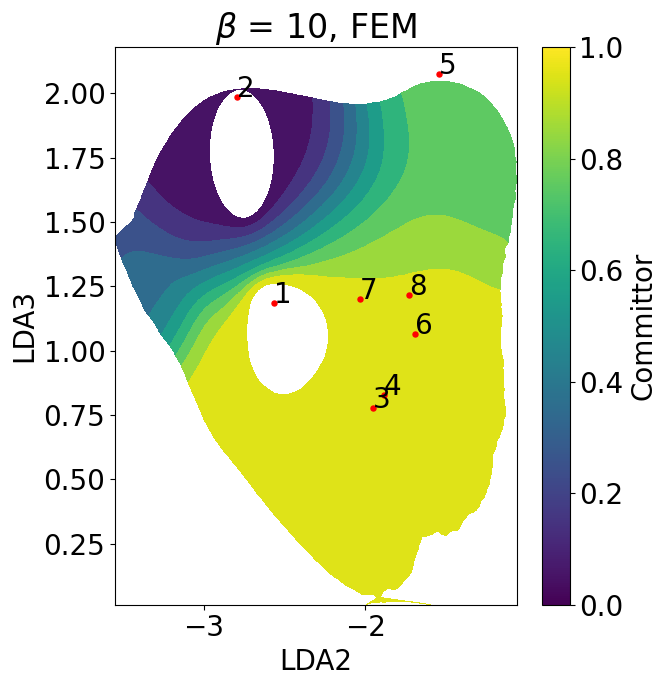

In [19]:
plt.figure(figsize=(7,7))    
plt.rcParams.update({'font.size': 20})  
plt.tricontourf(pts[:,0], pts[:,1],tri,q,np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]))
plt.scatter(CVlist[:,0],CVlist[:,1],s = 13, c = 'red')
for j in range(8):
    plt.text(CVlist[j,0],CVlist[j,1],str(j+1),color = 'black')
plt.colorbar(label="Committor", orientation="vertical")
plt.xlabel("LDA2")
plt.ylabel("LDA3")
# axes=plt.gca()
# axes.set_aspect(1)
plt.tight_layout()
plt.title(r'$\beta$' + ' = ' + str(beta) + ', FEM')
fname = "Figures/FEM_Committor_LDA23_BETA"+str(beta)+".pdf"
plt.savefig(fname)

np.savez("Data/Committor_LDA23_BETA"+str(beta) + '.npz', points = pts, committor = q, tri = tri, CVlist = CVlist)


In [22]:
class LJ8_3(nn.Module):
    """
    Feedforward neural network with a user-defined number of hidden layers.
    
    Args:
        in_size (int): Size of input layer.
        hidden_sizes (list of int): Sizes of hidden layers.
        out_size (int): Size of output layer.
    """
    def __init__(self, in_size, hidden_sizes, out_size):
        super().__init__()
        layers = []

        # Input to first hidden layer
        layers.append(nn.Linear(in_size, hidden_sizes[0]))
        layers.append(nn.ReLU())

        # Hidden layers
        for i in range(len(hidden_sizes) - 1):
            layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            layers.append(nn.ReLU())

        # Final output layer
        layers.append(nn.Linear(hidden_sizes[-1], out_size))
        layers.append(nn.Sigmoid())

        # Combine all layers
        self.model = nn.Sequential(*layers)

    def forward(self, xb):
        return self.model(xb)

In [43]:
beta = 20
fname = "Data/Committor_LDA23_BETA"+str(beta) + '.npz'
inData = np.load(fname)
pts = inData["points"]
Q = inData["committor"]
tri = inData['tri']
CVlist = inData['CVlist']
print(f"Shape of trajectory data:{pts.shape}")
train_data = torch.tensor(pts,dtype=torch.float32)
Q = torch.tensor(Q,dtype=torch.float32)
# ptsA = torch.tensor(np.loadtxt("FEMdataBETA" + str(beta) +"/ptsA.csv", delimiter=','), dtype=torch.float32)
# ptsB = torch.tensor(np.loadtxt("FEMdataBETA" + str(beta) +"/ptsB.csv", delimiter=','), dtype=torch.float32)

ptsA = torch.tensor(np.loadtxt(dirname +"ptsA.csv", delimiter=',', dtype=float), dtype=torch.float32)
ptsB = torch.tensor(np.loadtxt(dirname +"ptsB.csv", delimiter=',', dtype=float), dtype=torch.float32)

train_data = torch.cat((train_data, ptsA, ptsB), 0)
Q = torch.cat((Q, torch.zeros(len(ptsA)), torch.ones(len(ptsB))), 0)

# initialization
input_size = 2
output_size = 1
if beta == 20:
    model = LJ8_3(input_size,[40,40],output_size)
else:
    model = LJ8_3(input_size,[25,25],output_size)
save_folder = "Data/Committor_LDA23_BETA"+str(beta)

Shape of trajectory data:(15038, 2)


In [44]:
for name, param in model.named_parameters():
    shape_str = ",".join(map(str, param.shape))
    filename = os.path.join(save_folder, f"{name.replace('.', '_')}_[{shape_str}].csv")

    if os.path.exists(filename):
        param_data = np.loadtxt(filename, delimiter=",")  # Load CSV data
        param_data = torch.tensor(param_data, dtype=param.dtype)  # Convert to tensor

        # **Fix shape mismatches**
        if param.shape != param_data.shape:
            if len(param.shape) == 2 and len(param_data.shape) == 1:
                param_data = param_data.view(param.shape)  # Reshape 1D -> 2D
            elif len(param.shape) == 1 and param_data.numel() == 1:
                param_data = param_data.view(1)  # Reshape scalar -> (1,)
            else:
                print(f"Skipping {name} due to incompatible shape {param_data.shape}")

        # Load into model if shape matches
        if param.shape == param_data.shape:
            param.data.copy_(param_data)
            print(f"Loaded: {filename}")
        else:
            print(f"Shape mismatch for {name}: expected {param.shape}, got {param_data.shape}")
    else:
        print(f"File not found: {filename}")

# Set model to evaluation mode
model.eval()

q_NN = model(train_data)

Loaded: Data/Committor_min01_LDA23_BETA20/linear1_weight_[40,2].csv
Loaded: Data/Committor_min01_LDA23_BETA20/linear1_bias_[40].csv
Loaded: Data/Committor_min01_LDA23_BETA20/linear2_weight_[40,40].csv
Loaded: Data/Committor_min01_LDA23_BETA20/linear2_bias_[40].csv
Loaded: Data/Committor_min01_LDA23_BETA20/linear3_weight_[40,40].csv
Loaded: Data/Committor_min01_LDA23_BETA20/linear3_bias_[40].csv
Loaded: Data/Committor_min01_LDA23_BETA20/linear4_weight_[1,40].csv
Loaded: Data/Committor_min01_LDA23_BETA20/linear4_bias_[1].csv


In [45]:
def read_bins_data(fname):
    # read free energy
    bins = []
    with open(fname, "r") as f:
        for line in f:
            # cleaning the bad chars in line
            line = line.strip()
            line = line.strip(" \\n")
            line = re.sub(r"(-[0-9]+\.)", r" \1", line)
            # print(line)
            values = [int(value) for value in line.split()]
            # print(values)
            bins.append(values)
        print(np.shape(bins))
        bins = np.array(bins)
        print(np.shape(bins))
    
    return bins

In [46]:
fname = "Data/RtrajStochControl/Rtraj_bins_beta"+str(beta)+".txt"
bins = read_bins_data(fname)
muR = np.array(np.transpose(bins),dtype = float)
Z = np.sum(muR)*h1*h2
print(Z)
muR = muR/Z
for i in range(N2):
    for j in range(N1):
        if bins[j,i] == 0:
            muR[i,j] = np.nan

(129, 129)
(129, 129)
3522.38126606988


/var/folders/tj/20hjj3p93ls3rkc91pc6nmb40000gn/T/ipykernel_39470/302364763.py:11: UserWarning: The following kwargs were not used by contour: 's'
  plt.tricontour(train_data[:,0].detach(), train_data[:,1].detach(),q_NN[:,0].detach(),np.array([1.0e-2,1-1e-2]),colors = 'black', s = 3.5)


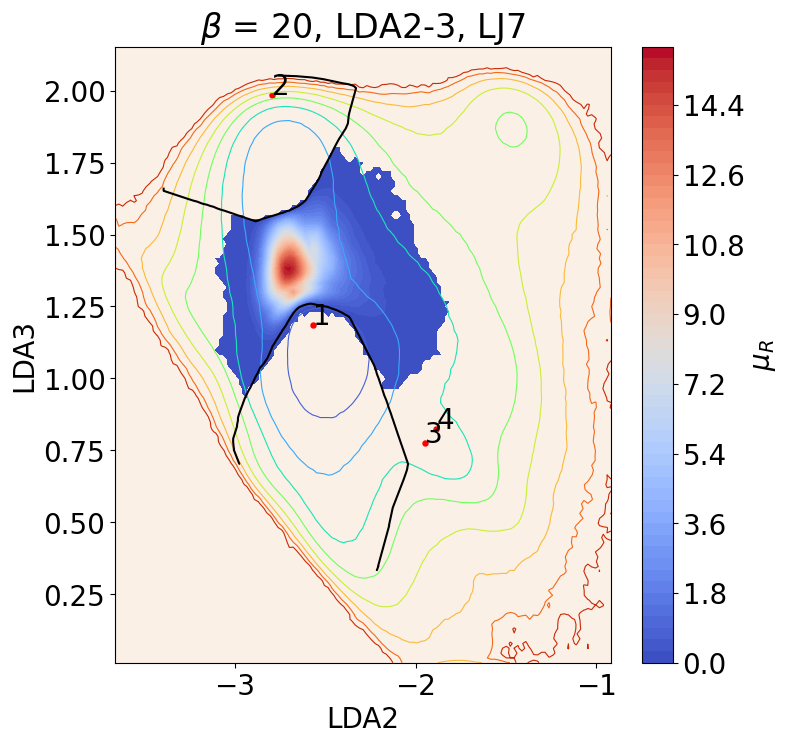

In [47]:
plt.figure(figsize=(8,8))
plt.contourf(CV1grid,CV2grid,muR,levels = 60, cmap = 'coolwarm')
cbar = plt.colorbar()
cbar.set_label(r'$\mu_R$', size=20)
plt.contour(CV1grid,CV2grid,FE, cmap = 'turbo', levels=10, linewidths=0.8) #cmap='turbo')
if beta == 10:
    plt.tricontour(train_data[:,0].detach(), train_data[:,1].detach(),q_NN[:,0].detach(),np.array([1.0e-2,1-1e-2]),colors = 'black', s = 3.5)
if beta == 15:
    plt.tricontour(train_data[:,0].detach(), train_data[:,1].detach(),q_NN[:,0].detach(),np.array([1.0e-2,1-1e-2]),colors = 'black', s = 3.5)
if beta == 20:
    plt.tricontour(train_data[:,0].detach(), train_data[:,1].detach(),q_NN[:,0].detach(),np.array([1.0e-2,1-1e-2]),colors = 'black', s = 3.5)

    Nmin = 4
for j in range(Nmin):
    plt.scatter(CVlist[j,0],CVlist[j,1],s = 13, c = 'red')
    plt.text(CVlist[j,0],CVlist[j,1],str(j+1),color = 'black')

plt.xlabel(r"LDA2")
plt.ylabel(r"LDA3")
# plt.ylim([-2,1.25])
plt.title(r'$\beta$' + ' = ' + str(beta) + ', LDA2-3, LJ7')
axes=plt.gca()
axes.set_facecolor('linen')
figname = "Figures/ProbDensityRtraj_LJ7_LDA23_beta"+str(beta)+".pdf"
plt.savefig(figname)